In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import models,layers,regularizers
from keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.layers import Conv2D,MaxPool2D,BatchNormalization,Dropout,Flatten,Input, Dense


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = tf.keras.utils.image_dataset_from_directory(directory = '/content/drive/MyDrive/dataset',
                                                   color_mode = 'rgb',
                                                   batch_size = 32,
                                                   image_size = (224,224),
                                                   shuffle=True,
                                                   seed = 2022)

Found 2045 files belonging to 2 classes.


In [ ]:
class_names= data.class_names
class_names

['cataract', 'glaucoma']

In [ ]:
for id, name in enumerate(class_names):
  print(f"{id} : {name}")

0 : cataract
1 : glaucoma


In [ ]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
batch[0].shape

(32, 224, 224, 3)

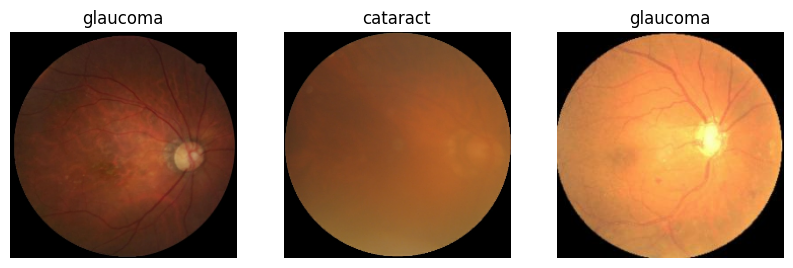

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
data = data.map(lambda x, y: (x/255, y))

In [ ]:
sample = data.as_numpy_iterator().next()

In [ ]:
print(sample[0].min())
print(sample[0].max())

0.0
1.0


In [ ]:
print("Total number of batchs = ",len(data))

Total number of batchs =  64


In [ ]:
train_size = int(0.7 * len(data)) +1
val_size = int(0.2 * len(data))
test_size = int(0.1 * len(data))

In [ ]:
train = data.take(train_size)
remaining = data.skip(train_size)
val = remaining.take(val_size)
test = remaining.skip(val_size)

In [ ]:
print(f"# train batchs = {len(train)}, # validate batchs = {len(val)}, # test batch = {len(test)}")
len(train) + len(val) + len(test)

# train batchs = 45, # validate batchs = 12, # test batch = 7


64

In [ ]:
test_iter = test.as_numpy_iterator()

In [ ]:
test_set = {"images":np.empty((0,224,224,3)), "labels":np.empty(0)}
while True:
  try:
    batch = test_iter.next()
    test_set['images'] = np.concatenate((test_set['images'], batch[0]))
    test_set['labels'] = np.concatenate((test_set['labels'], batch[1]))
  except:
    break

In [ ]:
y_true = test_set['labels']

In [ ]:
# Displaying history loss/accuracy
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_his(history):
    plt.figure(figsize=(15,12))
    metrics = ['accuracy', 'loss']
    for i, metric in enumerate(metrics):
        plt.subplot(220+1+i)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
    plt.show()

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
from keras.layers import Dense, Dropout, Activation
image_size= 250
resnet1 = ResNet50(
    weights='imagenet',
    include_top= False ,
    input_shape=(224,224,3)
)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
resnet1.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
for layer in resnet1.layers:
	layer.trainable = False
resnet1.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(resnet1)
model.add(Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Flatten())
model.add(Dense(2,activation="sigmoid"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dense (Dense)               (None, 7, 7, 256)         524544    
                                                                 
 dropout (Dropout)           (None, 7, 7, 256)         0         
                                                                 
 dense_1 (Dense)             (None, 7, 7, 128)         32896     
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_2 (Dense)             (None, 2)                 1

In [ ]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [ ]:
from keras import callbacks
early_stop = callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=20,
        verbose=1,
        mode="max",
        restore_best_weights=True,
     )

history = model.fit(
    train,
    validation_data=val,
    epochs = 10,
    callbacks=[early_stop],
)

Epoch 1/10
45/45 [==============================] - 443s 10s/step - loss: 0.9309 - accuracy: 0.5514 - val_loss: 0.6591 - val_accuracy: 0.6068
Epoch 2/10
45/45 [==============================] - 435s 10s/step - loss: 0.6582 - accuracy: 0.6215 - val_loss: 0.6302 - val_accuracy: 0.6406
Epoch 3/10
45/45 [==============================] - 381s 8s/step - loss: 0.6571 - accuracy: 0.6187 - val_loss: 0.6319 - val_accuracy: 0.6302
Epoch 4/10
45/45 [==============================] - 430s 10s/step - loss: 0.6511 - accuracy: 0.6139 - val_loss: 0.6410 - val_accuracy: 0.6276
Epoch 5/10
45/45 [==============================] - 427s 9s/step - loss: 0.6493 - accuracy: 0.6049 - val_loss: 0.6668 - val_accuracy: 0.6042
Epoch 6/10
45/45 [==============================] - 432s 10s/step - loss: 0.6452 - accuracy: 0.6236 - val_loss: 0.6210 - val_accuracy: 0.6432
Epoch 7/10
45/45 [==============================] - 429s 10s/step - loss: 0.6429 - accuracy: 0.6326 - val_loss: 0.6316 - val_accuracy: 0.6510
Epoch 8/

In [ ]:
model.evaluate(test)